# Parameter Estimation Example 2: Kinetic Parameter Estimation

This example demonstrates kinetic parameter estimation for chemical reaction systems.

## Mathematical Formulation

For a chemical reaction system, we typically have:

**Material Balance:**
$$\frac{dC_i}{dt} = \sum_j \nu_{ij} r_j(C, T, k)$$

**Rate Expression:**
$$r_j = k_j f_j(C, T)$$

**Parameter Estimation Objective:**
$$\min_{k} \sum_{i,t} w_{i,t} \left(C_{i,\text{exp}}(t) - C_{i,\text{model}}(t)\right)^2$$

where:
- $C_i$ = concentration of species $i$
- $\nu_{ij}$ = stoichiometric coefficient  
- $r_j$ = reaction rate
- $k_j$ = kinetic parameters (to be estimated)
- $w_{i,t}$ = weighting factors

Here we work through an example of kinetic parameter estimation.

First we simulate the kinematic behaviour

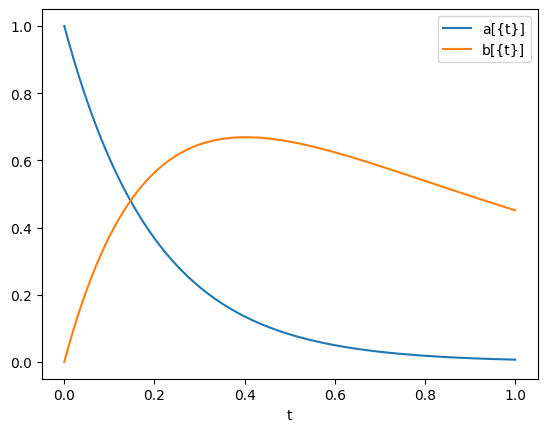

In [3]:
import pyomo.environ as pyo
from pyomo.dae import ContinuousSet, DerivativeVar, Simulator
import scipy

m = pyo.ConcreteModel()

m.t = ContinuousSet(bounds=(0,1))
m.a = pyo.Var(m.t)
m.b = pyo.Var(m.t)

m.k1 = pyo.Param(initialize=5)
m.k2 = pyo.Param(initialize=1)

m.dadt = DerivativeVar(m.a)
m.dbdt = DerivativeVar(m.b)

m.a[0].fix(1)
m.b[0].fix(0)

def _da(m, t):
    return m.dadt[t] == -m.k1*m.a[t]
m.da_con = pyo.Constraint(m.t, rule=_da)

def _db(m, t):
    return m.dbdt[t] == m.k1*m.a[t] - m.k2*m.b[t]
m.db_con = pyo.Constraint(m.t, rule=_db)

mysim = Simulator(m, package='scipy')
tsim, profiles = mysim.simulate(integrator='vode', numpoints=100)

import matplotlib.pyplot as plt

varorder = mysim.get_variable_order()
for idx, v in enumerate(varorder):
    plt.plot(tsim, profiles[:, idx], label=v)

plt.xlabel('t')
plt.legend(loc='best')
plt.show()

plt.show()


Now let's estimate the parameters

Ipopt 3.9.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Common Public License (CPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.9.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:      550
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       82

Total number of variables............................:      126
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       62
   

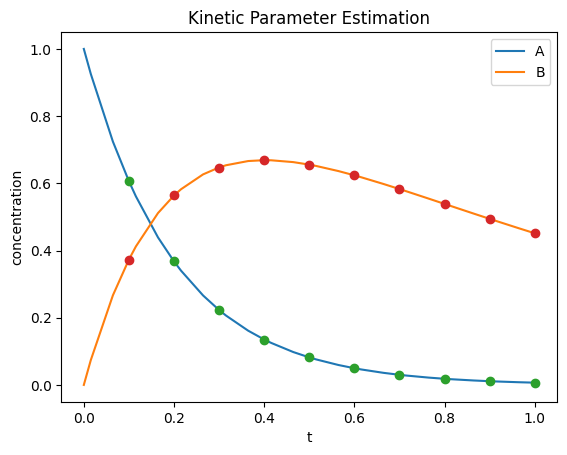

In [2]:
import pyomo.environ as pyo
from pyomo.dae import ContinuousSet, DerivativeVar

a_conc = {0.1:0.606, 0.2:0.368, 0.3:0.223, 0.4:0.135, 0.5:0.082,
          0.6:0.05, 0.7:0.03, 0.8:0.018, 0.9:0.011, 1.0:0.007}

b_conc = {0.1:0.373, 0.2:0.564, 0.3:0.647, 0.4:0.669, 0.5:0.656,
          0.6:0.624, 0.7:0.583, 0.8:0.539, 0.9:0.494, 1.0:0.451}

m = pyo.ConcreteModel()

m.meas_time = pyo.Set(initialize=sorted(a_conc.keys()),ordered=True)
m.ameas = pyo.Param(m.meas_time, initialize=a_conc)
m.bmeas = pyo.Param(m.meas_time, initialize=b_conc)

m.time = ContinuousSet(initialize=m.meas_time, bounds=(0,1))

m.a = pyo.Var(m.time, bounds=(0,1))
m.b = pyo.Var(m.time, bounds=(0,1))

m.dadt = DerivativeVar(m.a)
m.dbdt = DerivativeVar(m.b)

m.k1 = pyo.Var()
m.k2 = pyo.Var()

def _a_diffeq(m,t):
    return m.dadt[t] == -m.k1*m.a[t]
m.a_diffeq = pyo.Constraint(m.time, rule=_a_diffeq)

def _b_diffeq(m,t):
    return m.dbdt[t] == m.k1*m.a[t] - m.k2*m.b[t]
m.b_diffeq = pyo.Constraint(m.time, rule=_b_diffeq)

m.ainit = pyo.Constraint(expr=m.a[0]==1)
m.binit = pyo.Constraint(expr=m.b[0]==0)

def _obj(m):
    return sum((m.a[t]-m.ameas[t])**2+(m.b[t]-m.bmeas[t])**2 for t in m.meas_time)
m.obj = pyo.Objective(rule=_obj)

discretizer = pyo.TransformationFactory('dae.collocation')
discretizer.apply_to(m,nfe=10,ncp=3,scheme='LAGRANGE-RADAU')

solver = pyo.SolverFactory('ipopt')
solver.solve(m, tee=True)

print('k1= '+str(pyo.value(m.k1)))
print('k2= '+str(pyo.value(m.k2)))

meas_time = list(m.meas_time)
a_meas = [pyo.value(m.ameas[i]) for i in m.meas_time]
b_meas = [pyo.value(m.bmeas[i]) for i in m.meas_time]

t = list(m.time)
a = [pyo.value(m.a[i]) for i in m.time]
b = [pyo.value(m.b[i]) for i in m.time]
    
import matplotlib.pyplot as plt

plt.plot(t,a,label='A')
plt.plot(t,b,label='B')
plt.plot(meas_time,a_meas,'o')
plt.plot(meas_time,b_meas,'o')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('concentration')
plt.title('Kinetic Parameter Estimation')
plt.show()


Ipopt 3.9.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Common Public License (CPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.9.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:      550
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       82

Total number of variables............................:      126
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       62
   

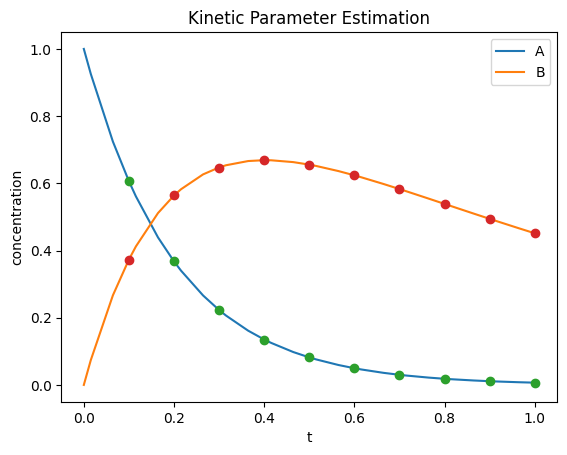

In [3]:
import pyomo.environ as pyo
from pyomo.dae import ContinuousSet, DerivativeVar

a_conc = {0.1:0.606, 0.2:0.368, 0.3:0.223, 0.4:0.135, 0.5:0.082,
          0.6:0.05, 0.7:0.03, 0.8:0.018, 0.9:0.011, 1.0:0.007}

b_conc = {0.1:0.373, 0.2:0.564, 0.3:0.647, 0.4:0.669, 0.5:0.656,
          0.6:0.624, 0.7:0.583, 0.8:0.539, 0.9:0.494, 1.0:0.451}

m = pyo.ConcreteModel()

m.meas_time = pyo.Set(initialize=sorted(a_conc.keys()),ordered=True)
m.ameas = pyo.Param(m.meas_time, initialize=a_conc)
m.bmeas = pyo.Param(m.meas_time, initialize=b_conc)

m.time = ContinuousSet(initialize=m.meas_time, bounds=(0,1))

m.a = pyo.Var(m.time, bounds=(0,1))
m.b = pyo.Var(m.time, bounds=(0,1))

m.dadt = DerivativeVar(m.a)
m.dbdt = DerivativeVar(m.b)

m.k1 = pyo.Var()
m.k2 = pyo.Var()

def _a_diffeq(m,t):
    return m.dadt[t] == -m.k1*m.a[t]
m.a_diffeq = pyo.Constraint(m.time, rule=_a_diffeq)

def _b_diffeq(m,t):
    return m.dbdt[t] == m.k1*m.a[t] - m.k2*m.b[t]
m.b_diffeq = pyo.Constraint(m.time, rule=_b_diffeq)

m.ainit = pyo.Constraint(expr=m.a[0]==1)
m.binit = pyo.Constraint(expr=m.b[0]==0)

def _obj(m):
    return sum((m.a[t]-m.ameas[t])**2+(m.b[t]-m.bmeas[t])**2 for t in m.meas_time)
m.obj = pyo.Objective(rule=_obj)

discretizer = pyo.TransformationFactory('dae.collocation')
discretizer.apply_to(m,nfe=10,ncp=3,scheme='LAGRANGE-RADAU')

solver = pyo.SolverFactory('ipopt')
solver.solve(m, tee=True)

print('k1= '+str(pyo.value(m.k1)))
print('k2= '+str(pyo.value(m.k2)))

meas_time = list(m.meas_time)
a_meas = [pyo.value(m.ameas[i]) for i in m.meas_time]
b_meas = [pyo.value(m.bmeas[i]) for i in m.meas_time]

t = list(m.time)
a = [pyo.value(m.a[i]) for i in m.time]
b = [pyo.value(m.b[i]) for i in m.time]
    
import matplotlib.pyplot as plt

plt.plot(t,a,label='A')
plt.plot(t,b,label='B')
plt.plot(meas_time,a_meas,'o')
plt.plot(meas_time,b_meas,'o')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('concentration')
plt.title('Kinetic Parameter Estimation')
plt.show()
